## This file's purpose is to plot the average telemety files in Relation based kd

In [1]:
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [2]:
run_files = [
    Path("../../logs/telemetry/2nd/relation/22921/rpg-93-5.jsonl"),
    Path("../../logs/telemetry/2nd/relation/22922/rpg-93-5.jsonl"),
    Path("../../logs/telemetry/2nd/relation/22926/rpg-93-5.jsonl"),
    Path("../../logs/telemetry/2nd/relation/22928/rpg-93-5.jsonl"),
    Path("../../logs/telemetry/2nd/relation/22929/rpg-93-5.jsonl"),
]

print("Found", len(run_files), "files")
for f in run_files:
    print(" -", f)


Found 5 files
 - ../../logs/telemetry/2nd/relation/22921/rpg-93-5.jsonl
 - ../../logs/telemetry/2nd/relation/22922/rpg-93-5.jsonl
 - ../../logs/telemetry/2nd/relation/22926/rpg-93-5.jsonl
 - ../../logs/telemetry/2nd/relation/22928/rpg-93-5.jsonl
 - ../../logs/telemetry/2nd/relation/22929/rpg-93-5.jsonl


In [3]:
def load_telemetry_file(path: Path) -> pd.DataFrame:
    records = []
    with path.open("r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            entry = json.loads(line)
            ts = entry["timestamp"]
            for gpu in entry["gpus"]:
                records.append({
                    "timestamp": ts,
                    "gpu_index": gpu["gpu_index"],
                    "gpu_name": gpu.get("gpu_name"),
                    "power_watts": gpu.get("power_watts"),
                    "energy_mJ": gpu.get("energy_mJ"),
                    "gpu_util": gpu.get("gpu_utilization_percent"),
                    "mem_util": gpu.get("memory_utilization_percent"),
                    "mem_used_MB": gpu.get("memory_used_MB"),
                    "temp_C": gpu.get("temperature_C"),
                })
    df = pd.DataFrame(records)
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df = df.sort_values(["timestamp", "gpu_index"]).reset_index(drop=True)
    t0 = df["timestamp"].min()
    df["elapsed_s"] = (df["timestamp"] - t0).dt.total_seconds()
    return df


def compute_run_average(df: pd.DataFrame) -> pd.DataFrame:
    # per-second, averaged over GPUs
    df["t"] = df["elapsed_s"].round().astype(int)
    return (
        df.groupby("t")[["power_watts", "gpu_util", "mem_util", "mem_used_MB", "temp_C"]]
          .mean()
          .reset_index()
    )

all_runs = []
for f in run_files:
    df_raw = load_telemetry_file(f)
    df_avg = compute_run_average(df_raw)
    df_avg["run_file"] = f.name
    all_runs.append(df_avg)


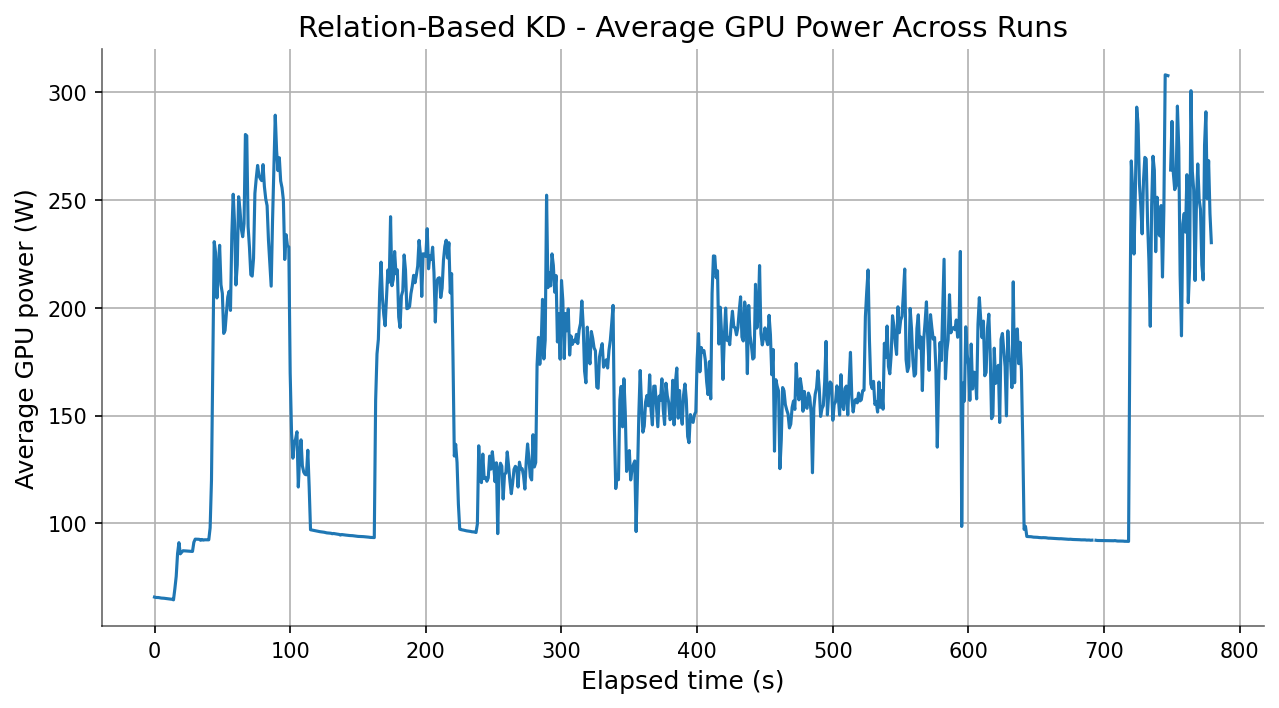

In [4]:
# Merge all runs on 't' and compute mean
merged = None
for df in all_runs:
    d = df.set_index("t")
    if merged is None:
        merged = d
    else:
        merged = merged.join(d, how="outer", rsuffix="_r")

# -----------------------------
# Nice global style tweaks
# -----------------------------
plt.style.use("default")
plt.rcParams.update({
    "figure.dpi": 150,
    "axes.labelsize": 12,
    "axes.titlesize": 14,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
})

fig, ax = plt.subplots(figsize=(10, 5))

avg_curve = pd.DataFrame()
avg_curve["t"] = merged.index
avg_curve["power_avg"] = merged.filter(like="power_watts").mean(axis=1)
avg_curve = avg_curve.sort_values("t").reset_index(drop=True)

# plt.figure(figsize=(10, 5))
# plt.plot(avg_curve["t"], avg_curve["power_avg"])
ax.plot(
    avg_curve["t"],
    avg_curve["power_avg"]
)

plt.xlabel("Elapsed time (s)")
plt.ylabel("Average GPU power (W)")
plt.title("Relation-Based KD - Average GPU Power Across Runs")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_alpha(0.6)
ax.spines["bottom"].set_alpha(0.6)

plt.grid(True)
plt.show()


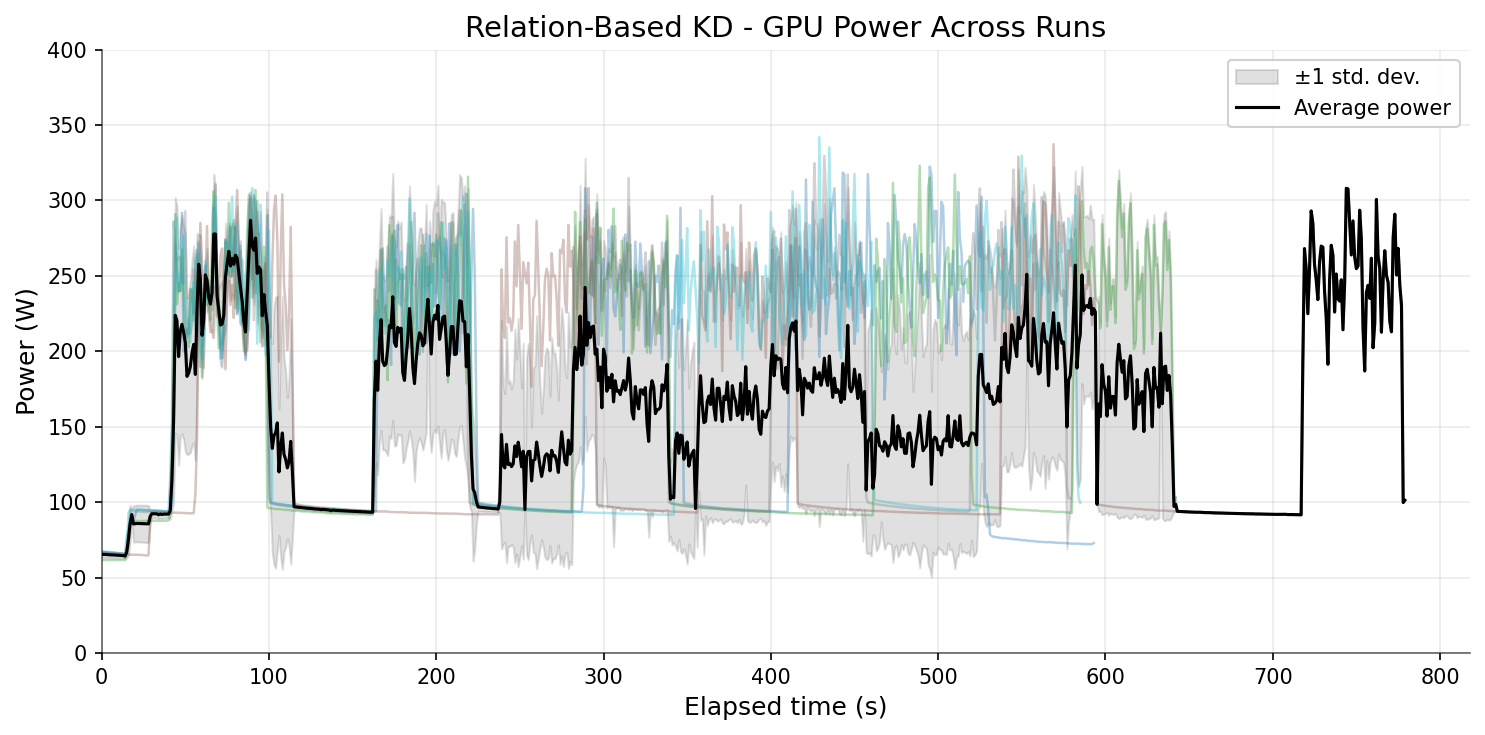

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Compute mean and std from `merged`
# -----------------------------
power_cols = [c for c in merged.columns if "power_watts" in c]

t = merged.index.values
mean_power = merged[power_cols].mean(axis=1)
std_power  = merged[power_cols].std(axis=1)

# -----------------------------
# Nice global style tweaks
# -----------------------------
plt.style.use("default")
plt.rcParams.update({
    "figure.dpi": 150,
    "axes.labelsize": 12,
    "axes.titlesize": 14,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
})

fig, ax = plt.subplots(figsize=(10, 5))

# -----------------------------
# Colorful per-run lines
# -----------------------------
colors = plt.cm.tab10(np.linspace(0, 1, len(all_runs)))

for df, color in zip(all_runs, colors):
    ax.plot(
        df["t"],
        df["power_watts"],
        color=color,
        alpha=0.35,
        linewidth=1.2,
    )

# -----------------------------
# Shaded std band (same)
# -----------------------------
ax.fill_between(
    t,
    mean_power - std_power,
    mean_power + std_power,
    color="black",
    alpha=0.12,
    label="±1 std. dev.",
)

# -----------------------------
# Mean curve: thinner black line
# -----------------------------
ax.plot(
    t,
    mean_power,
    color="black",
    linewidth=1.5,   # << thinner average line
    label="Average power",
)

# -----------------------------
# Formatting
# -----------------------------
ax.set_xlim(left=0)
ax.set_ylim(0, 400)
ax.set_xlabel("Elapsed time (s)")
ax.set_ylabel("Power (W)")
ax.set_title("Relation-Based KD - GPU Power Across Runs")

ax.grid(True, which="both", axis="both", alpha=0.25)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_alpha(0.6)
ax.spines["bottom"].set_alpha(0.6)

leg = ax.legend(frameon=True)
leg.get_frame().set_alpha(0.9)

fig.tight_layout()
plt.show()


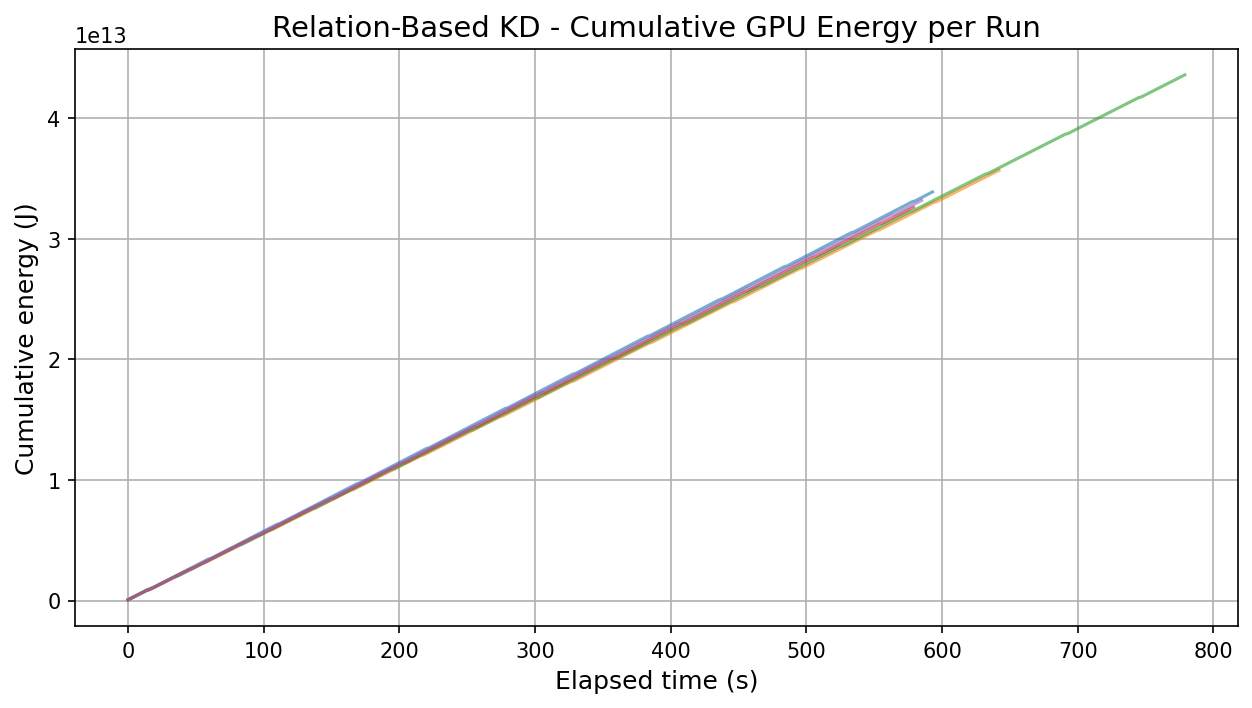

In [6]:
def compute_run_energy(df_raw: pd.DataFrame) -> pd.DataFrame:
    # sum energy across GPUs per timestamp (mJ), then cumulative
    df_raw["t"] = df_raw["elapsed_s"].round().astype(int)
    energy_per_t = (
        df_raw.groupby("t")["energy_mJ"]
              .sum()  # sum over GPUs
              .sort_index()
    )
    # convert mJ → J
    E_J = energy_per_t.cumsum() / 1000.0
    out = pd.DataFrame({"t": E_J.index, "E_J": E_J.values})
    return out

energy_runs = []
for f in run_files:
    df_raw = load_telemetry_file(f)
    e_df = compute_run_energy(df_raw)
    e_df["run_file"] = f.name
    energy_runs.append(e_df)

plt.figure(figsize=(10, 5))
for e_df in energy_runs:
    plt.plot(e_df["t"], e_df["E_J"], alpha=0.6)

plt.xlabel("Elapsed time (s)")
plt.ylabel("Cumulative energy (J)")
plt.title("Relation-Based KD - Cumulative GPU Energy per Run")
plt.grid(True)
plt.show()


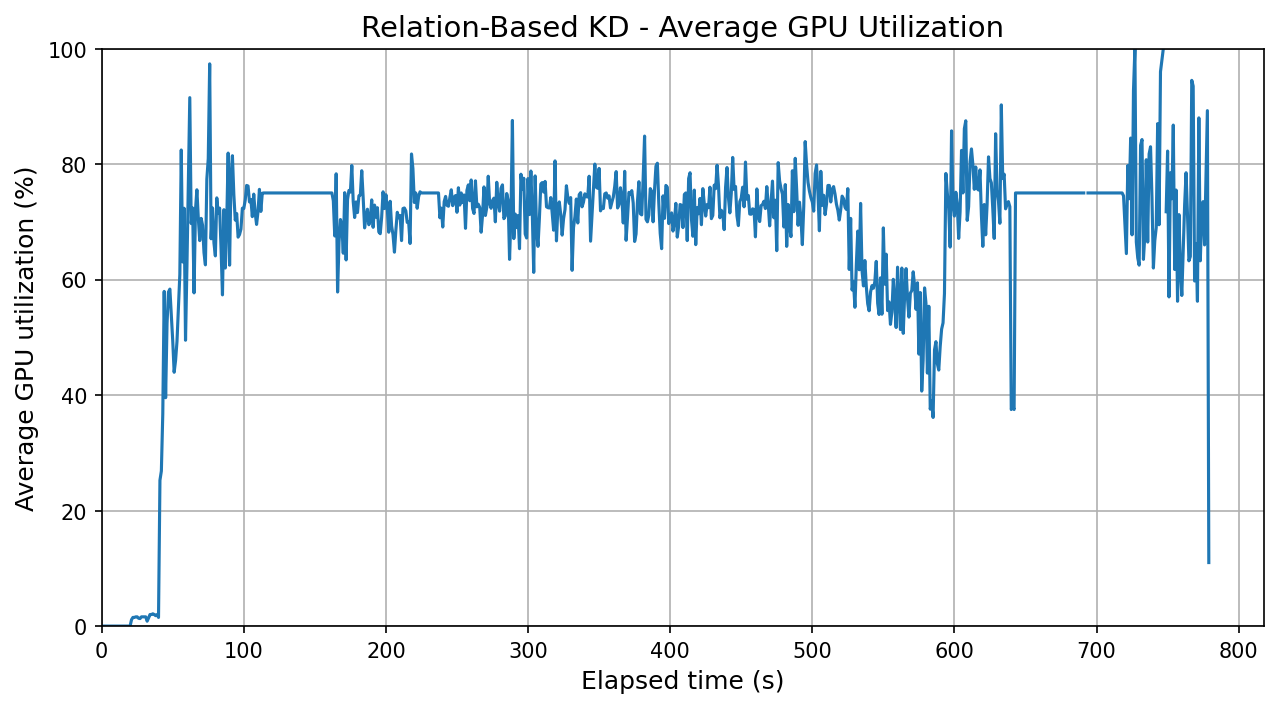

In [7]:
avg_curve["gpu_util_avg"] = merged.filter(like="gpu_util").mean(axis=1)

plt.figure(figsize=(10, 5))
plt.plot(avg_curve["t"], avg_curve["gpu_util_avg"])
plt.xlim(left=0)
plt.ylim(0, 100) 
plt.xlabel("Elapsed time (s)")
plt.ylabel("Average GPU utilization (%)")
plt.title("Relation-Based KD - Average GPU Utilization")
plt.grid(True)
plt.show()


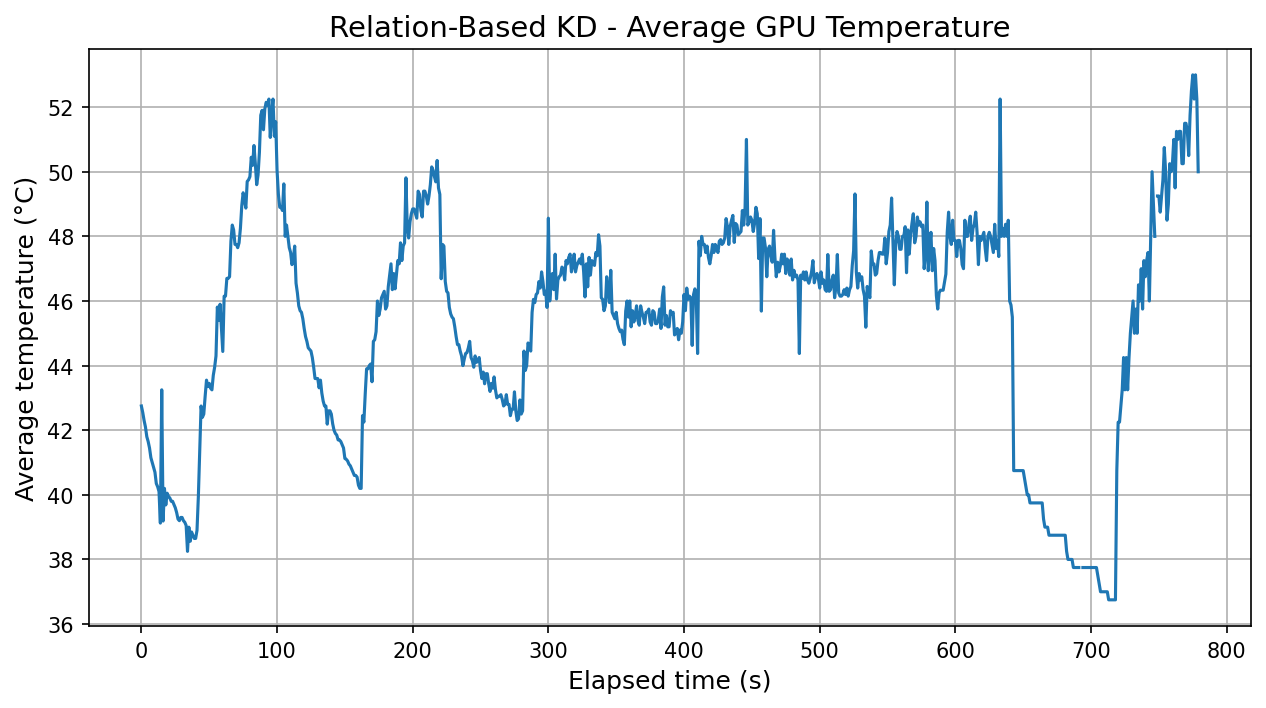

In [8]:
avg_curve["temp_avg"] = merged.filter(like="temp_C").mean(axis=1)

plt.figure(figsize=(10, 5))
plt.plot(avg_curve["t"], avg_curve["temp_avg"])
plt.xlabel("Elapsed time (s)")
plt.ylabel("Average temperature (°C)")
plt.title("Relation-Based KD - Average GPU Temperature")
plt.grid(True)
plt.show()


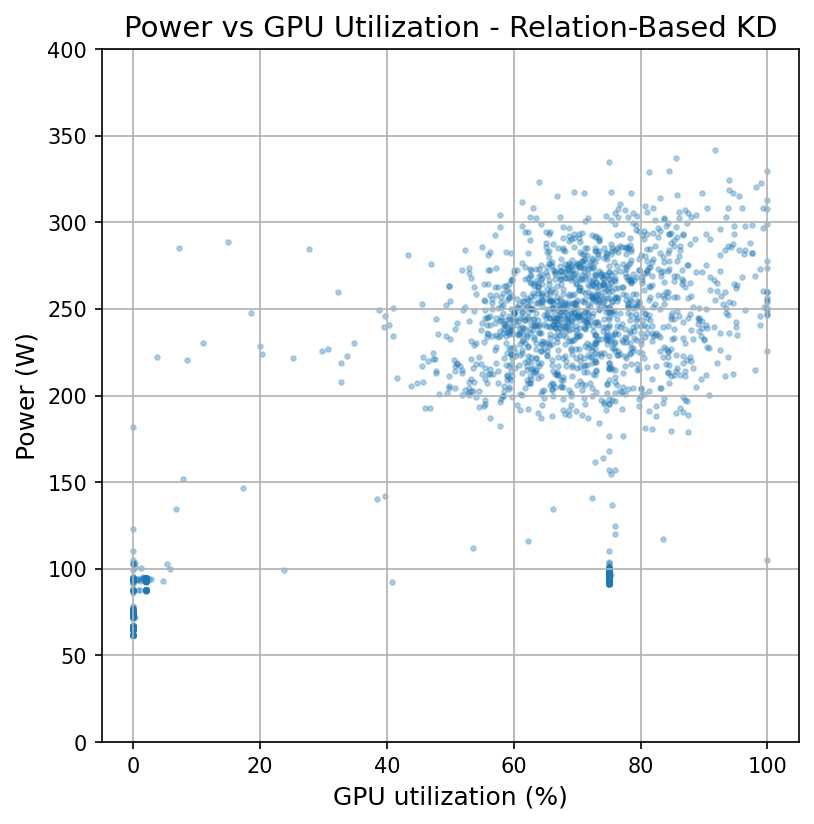

Correlation (power vs gpu_util): 0.2536105602415723


In [9]:
concat = pd.concat(all_runs, ignore_index=True)

plt.figure(figsize=(6, 6))
plt.scatter(concat["gpu_util"], concat["power_watts"], s=5, alpha=0.3)
plt.xlabel("GPU utilization (%)")
plt.ylabel("Power (W)")
plt.title("Power vs GPU Utilization - Relation-Based KD")
plt.ylim(0,400)
plt.grid(True)
plt.show()

# optional: correlation value
corr = concat[["gpu_util", "power_watts"]].corr().iloc[0, 1]
print("Correlation (power vs gpu_util):", corr)


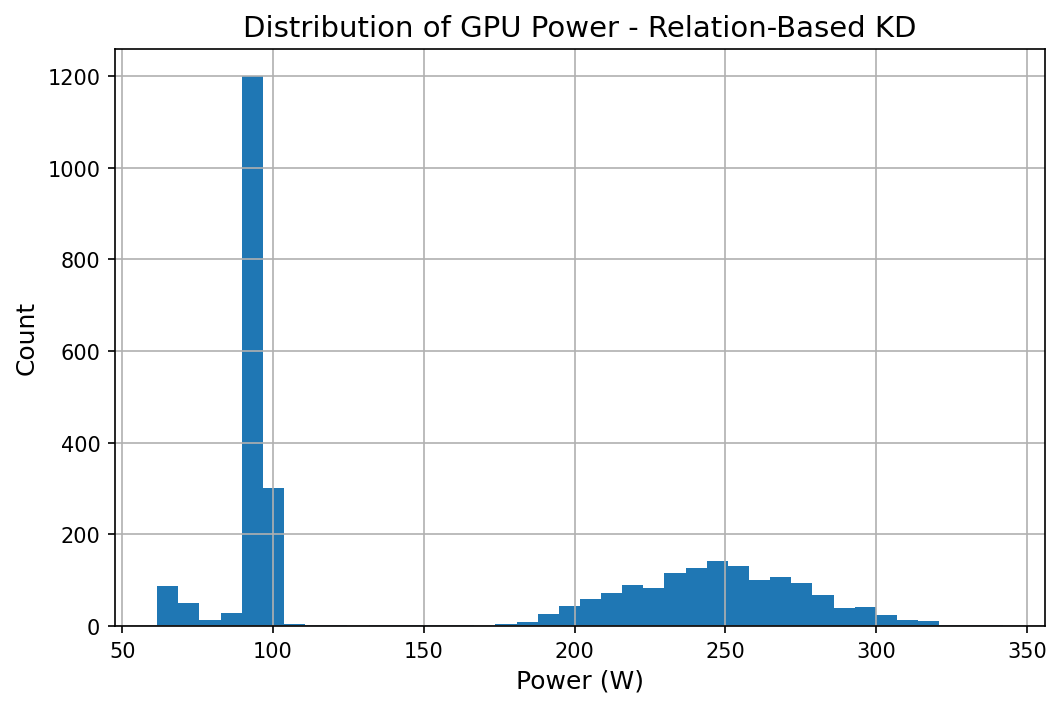

In [10]:
plt.figure(figsize=(8, 5))
plt.hist(concat["power_watts"].dropna(), bins=40)
plt.xlabel("Power (W)")
plt.ylabel("Count")
plt.title("Distribution of GPU Power - Relation-Based KD")
plt.grid(True)
plt.show()


/tmp/ipykernel_2261423/474580268.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(run_power, labels=run_labels, showfliers=False)


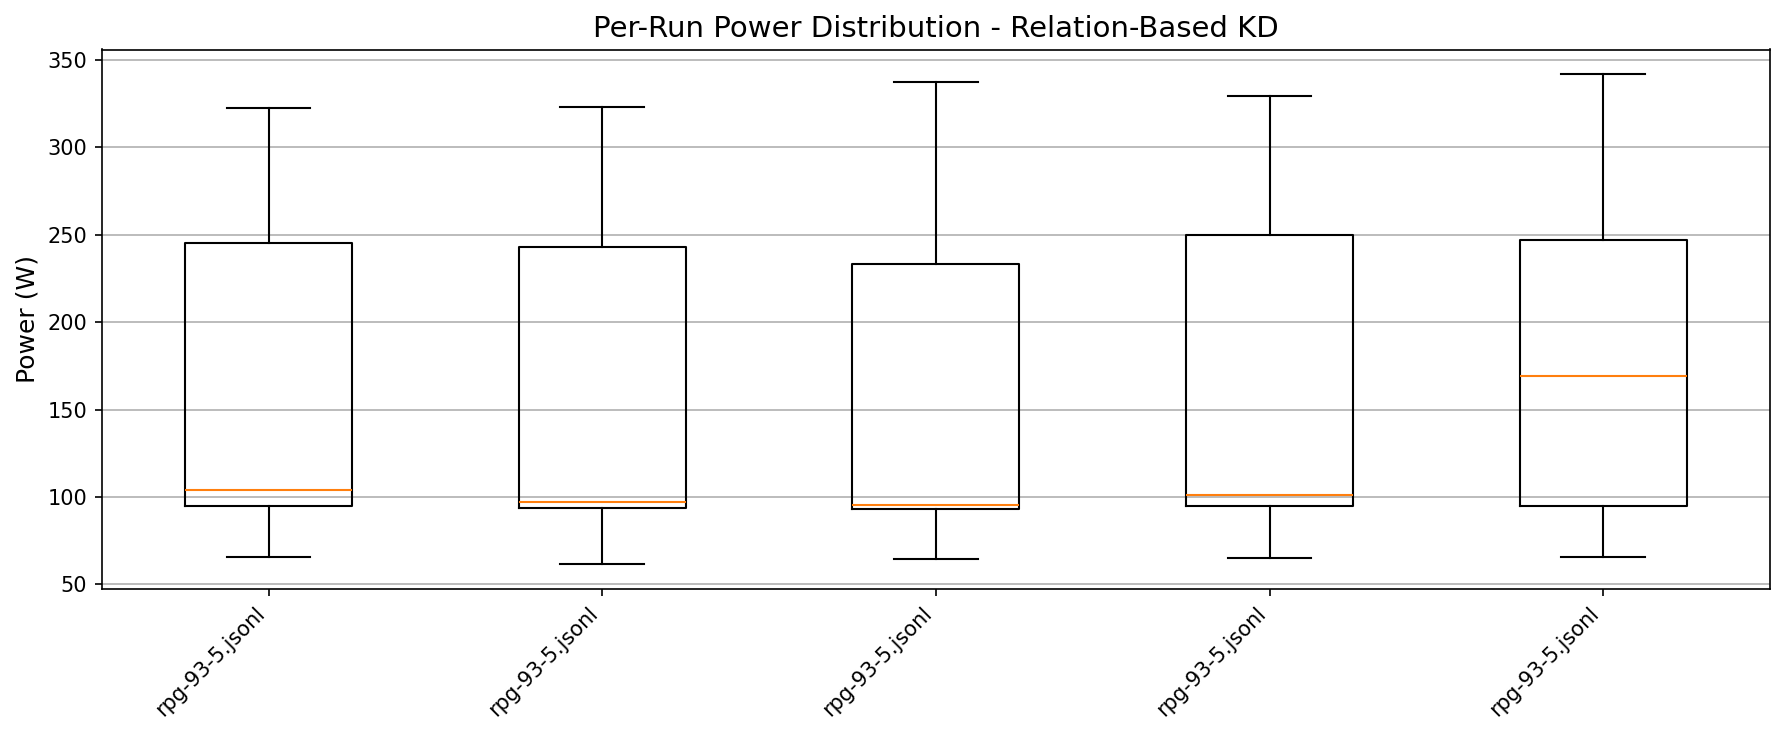

In [11]:
run_labels = []
run_power = []

for df in all_runs:
    run_labels.append(df["run_file"].iloc[0])
    run_power.append(df["power_watts"].dropna().values)

plt.figure(figsize=(12, 5))
plt.boxplot(run_power, labels=run_labels, showfliers=False)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Power (W)")
plt.title("Per-Run Power Distribution - Relation-Based KD")
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()


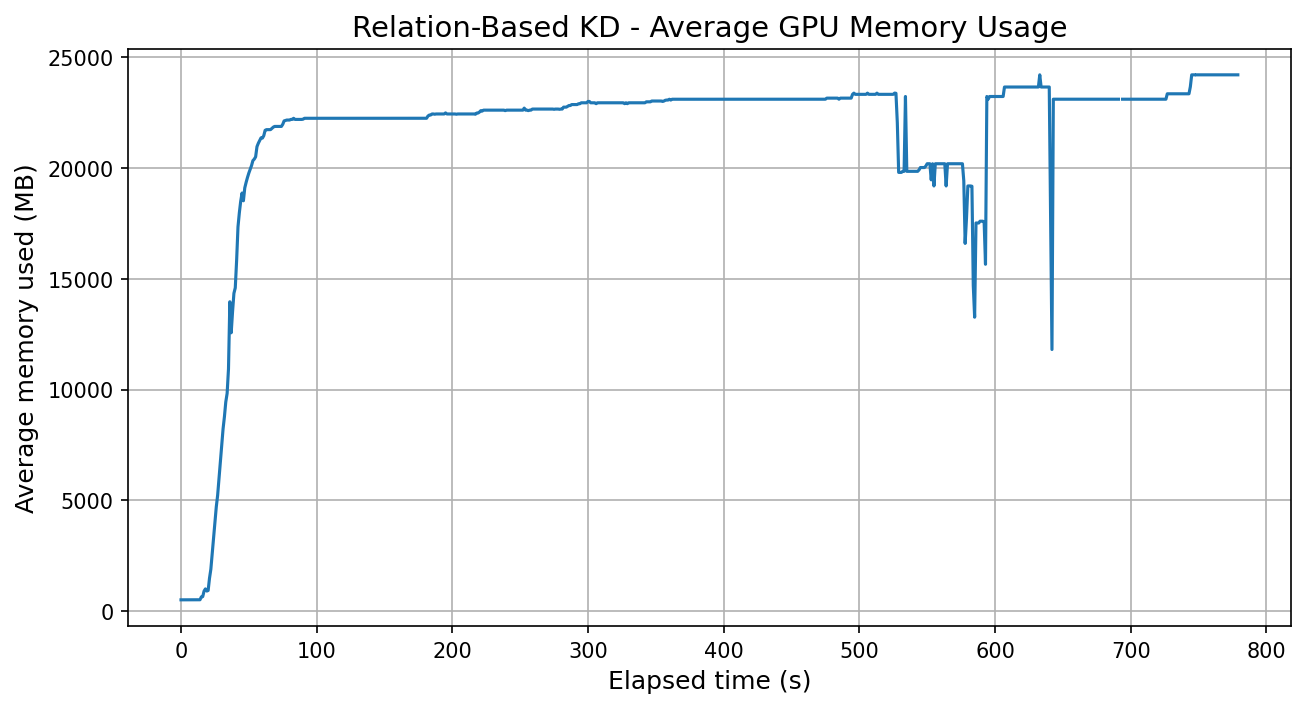

In [12]:
avg_curve["mem_used_avg"] = merged.filter(like="mem_used_MB").mean(axis=1)

plt.figure(figsize=(10, 5))
plt.plot(avg_curve["t"], avg_curve["mem_used_avg"])
plt.xlabel("Elapsed time (s)")
plt.ylabel("Average memory used (MB)")
plt.title("Relation-Based KD - Average GPU Memory Usage")
plt.grid(True)
plt.show()


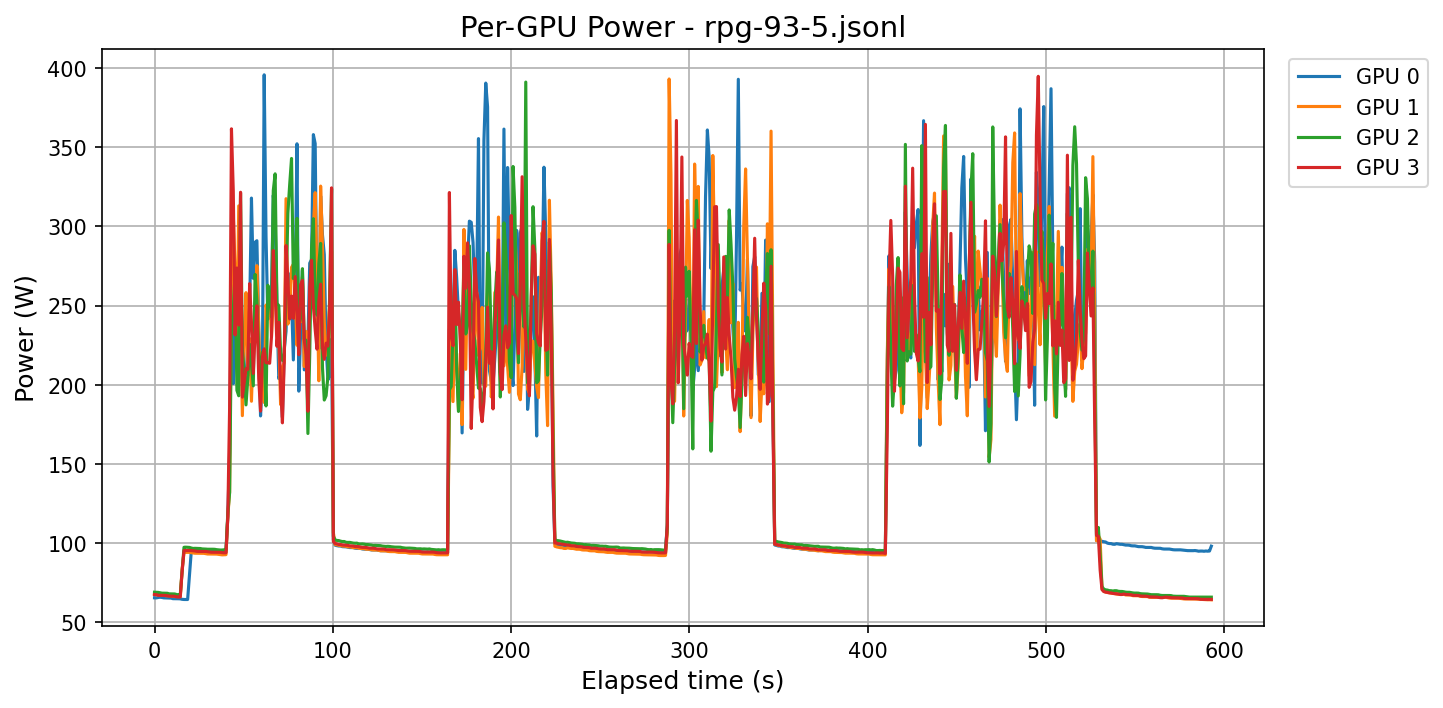

In [14]:
# pick first file as example
test_file = run_files[0]
df_raw = load_telemetry_file(test_file)

plt.figure(figsize=(10, 5))
for gpu_idx, sub in df_raw.groupby("gpu_index"):
    plt.plot(sub["elapsed_s"], sub["power_watts"], label=f"GPU {gpu_idx}")

plt.xlabel("Elapsed time (s)")
plt.ylabel("Power (W)")
plt.title(f"Per-GPU Power - {test_file.name}")
plt.legend(bbox_to_anchor=(1.15,1),loc="upper right")
plt.grid(True)
plt.show()
